In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import IPython.display as ipd
from pathlib import Path

In [3]:
import torch
import librosa
import numpy as np
import pandas as pd

In [4]:
from fastai import *
from fastai.conv_learner import *
from fastai.core import *
from fastai.metrics import *
from fastai.text import SortSampler, SortishSampler
from data_loading_utils import read_file
from preprocessing_utils import load_features
from helpers import *
from metrics import *
from models import *

In [5]:
PATH = Path('data/')
TRAIN_PATH = PATH/'audio_train_24000'
TRAIN_PATH_LMS = PATH/'audio_train_24000_1024_256_128'
TRAIN_PATH_LMS_TFM = PATH/'audio_train_tfms_24000_1024_256_128'

TEST_PATH = PATH/'audio_test_24000'
TEST_PATH_LMS = PATH/'audio_test_24000_1024_256_128'

sample_rate = 24000
n_features = 128
n_fft = 1024
hop_length = 256

In [6]:
train_csv = pd.read_csv(PATH/'train.csv')
train_fname = train_csv.fname.values
test_csv = pd.read_csv(PATH/'sample_submission.csv')
test_fname = test_csv.fname.values

labels = sorted(train_csv.label.unique())
label_idx = {label:i for i, label in enumerate(labels)}

train_y = train_csv.label.apply(lambda l: label_idx[l]).values
test_y = np.zeros(len(test_fname))

len(train_fname), len(train_y), len(test_fname), len(test_y)

(9473, 9473, 9400, 9400)

In [7]:
stats = (-40.813029, 20.376415)

norm = Normalize(*stats)
shift = RandomPitchTimeShift(min_x=1.0, max_x=1.0, max_y=1.2)
light = RandomLight()

trn_tfms = Transforms([light, shift, norm])
val_tfms = Transforms([norm])

In [8]:
((val_fname, trn_fname), (val_y, trn_y)) = get_first_split(train_fname, train_y, 7)
(len(trn_fname), len(trn_y), len(val_fname), len(val_y))

(8108, 8108, 1365, 1365)

In [9]:
num_classes = len(labels)
opt = optim.Adam
metrics = [accuracy, mapk]
loss = F.cross_entropy

In [10]:
bs = 16

In [11]:
trn_ds = AudioFilesDataset(TRAIN_PATH_LMS, trn_fname, trn_y, transform=trn_tfms)
trn_dl = AudioDataLoader2d(trn_ds,
                           batch_size=bs,
                           sampler=SortishSampler(trn_ds, key=lambda x: trn_ds[x][0].shape[1], bs=bs))

val_ds = AudioFilesDataset(TRAIN_PATH_LMS, val_fname, val_y, transform=val_tfms)
val_dl = AudioDataLoader2d(val_ds,
                           batch_size=bs,
                           sampler=SortSampler(val_ds, key=lambda x: val_ds[x][0].shape[1]))

aug_ds = AudioFilesDataset(TRAIN_PATH_LMS, val_fname, val_y, transform=trn_tfms)
aug_dl = AudioDataLoader2d(aug_ds,
                           batch_size=bs,
                           sampler=SortSampler(aug_ds, key=lambda x: aug_ds[x][0].shape[1]))

test_ds = AudioFilesDataset(TEST_PATH_LMS, test_fname, test_y, transform=val_tfms)
test_dl = AudioDataLoader2d(test_ds, batch_size=1)

test_aug_ds = AudioFilesDataset(TEST_PATH_LMS, test_fname, test_y, transform=trn_tfms)
test_aug_dl = AudioDataLoader2d(test_aug_ds, batch_size=1)

In [12]:
md = ModelData(PATH, trn_dl, val_dl, test_dl)
md.aug_dl = aug_dl
md.test_aug_dl = test_aug_dl

model = AudioResNet(BasicBlock, [4, 3, 2, 2], num_classes=num_classes).cuda()
learn = ConvLearner.from_model_data(model, md, crit=loss, metrics=metrics, opt_fn=opt)

In [13]:
learn.lr_find()

A Jupyter Widget

 72%|███████▏  | 366/507 [01:22<00:31,  4.42it/s, loss=13.9]

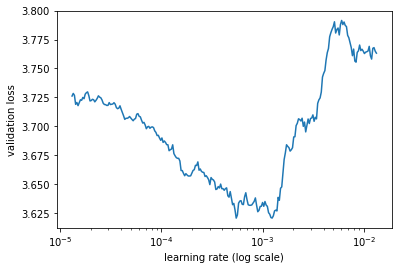

In [14]:
learn.sched.plot(n_skip_end=100)

In [15]:
lr = 1e-3
cycle_len = 30

learn.fit(lr, 1, cycle_len=cycle_len, use_clr_beta=(5, 20, 0.95, 0.75))
# 3, 3, 3
learn.save_cycle('24khz_1024_256_128_modified', cycle_len)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy   mapk       
    0      2.928018   3.06954    0.161172   0.245299  
    1      2.51679    2.343414   0.317216   0.435897  
    2      2.276248   2.119987   0.383883   0.50525   
    3      2.0906     2.010063   0.427106   0.534799  
    4      1.978858   1.937294   0.462271   0.573748  
    5      1.886082   1.768007   0.511355   0.60989   
    6      1.802416   1.67414    0.541392   0.639316  
    7      1.723549   1.780409   0.538462   0.639072  
    8      1.585571   1.652374   0.547253   0.652747  
    9      1.666462   1.770533   0.528938   0.630281  
    10     1.469661   1.944879   0.499634   0.600855  
    11     1.420495   1.441353   0.605128   0.696459  
    12     1.34725    1.627997   0.589011   0.687424  
    13     1.273888   1.51408    0.628571   0.714164  
    14     1.190718   1.316584   0.657143   0.738462  
    15     1.103097   1.347886   0.674725   0.745788  
    16     1.00353    1.237399   0.694505   0.763614  
    17   

In [ ]:
learn.load_cycle('24khz_1024_256_128_modified', cycle_len)

val_log_preds, val_targs = learn.predict_with_targs()
accuracy_np(val_log_preds, val_targs), mapk_np(val_log_preds, val_targs)

In [ ]:
val_aug_preds, val_aug_targs = learn.TTA()
preds = np.mean(val_aug_preds,0)
accuracy_np(preds, val_aug_targs), mapk_np(preds, val_aug_targs)

### Using the transformed audio files

In [ ]:
trn_ds = AudioFilesDataset(TRAIN_PATH_LMS_TFM, trn_fname, trn_y, use_tfms=True, transform=trn_tfms)
trn_dl = AudioDataLoader2d(trn_ds,
                           batch_size=bs,
                           sampler=SortishSampler(trn_ds, key=lambda x: trn_ds[x][0].shape[1], bs=bs))

In [ ]:
md = ModelData(PATH, trn_dl, val_dl, test_dl)
md.aug_dl = aug_dl
md.test_aug_dl = test_aug_dl

model = AudioResNet(BasicBlock, [3, 3, 3], num_classes=num_classes).cuda()
learn = ConvLearner.from_model_data(model, md, crit=loss, metrics=metrics, opt_fn=opt)

In [ ]:
learn.lr_find()
learn.sched.plot(n_skip_end=100)

In [ ]:
lr = 1e-3
cycle_len = 30

learn.fit(lr, 1, cycle_len=cycle_len, use_clr_beta=(5, 20, 0.95, 0.75))
# 3, 3, 3
learn.save_cycle('24khz_1024_256_128_data_aug_2', cycle_len)

In [ ]:
learn.load_cycle('24khz_1024_256_128_data_aug_2', cycle_len)

val_log_preds, val_targs = learn.predict_with_targs()
accuracy_np(val_log_preds, val_targs), mapk_np(val_log_preds, val_targs)

In [ ]:
val_aug_preds, val_aug_targs = learn.TTA()
preds = np.mean(val_aug_preds,0)
accuracy_np(preds, val_aug_targs), mapk_np(preds, val_aug_targs)

In [ ]:
learn.load_cycle('24khz_1024_256_128_data_aug_2', cycle_len)

lr=1e-4
learn.fit(lr, 1, cycle_len=5, use_clr_beta=(5, 20, 0.95, 0.75))

In [ ]:
learn.load_cycle('24khz_1024_256_128_data_aug_2', cycle_len)


#### Predict results...

In [ ]:
test_preds = learn.predict_with_targs(is_test=True)
predictions = test_preds[0]
predictions.shape

In [ ]:
top_3 = np.array(labels)[np.argsort(-predictions, axis=1)[:, :3]]
predicted_labels = [' '.join(list(x)) for x in top_3]
test_csv.label = predicted_labels
test_csv.to_csv('24K_first_fold_1.csv', index=False)
test_csv.head()

In [ ]:
test_preds_multi = learn.TTA(is_test=True)

In [ ]:
test_preds_multi[0].shape

In [ ]:
test_preds2 = np.mean(test_preds_multi[0],0)

In [ ]:
test_preds2.shape

In [ ]:
top_3 = np.array(labels)[np.argsort(-test_preds2, axis=1)[:, :3]]
predicted_labels = [' '.join(list(x)) for x in top_3]
test_csv.label = predicted_labels
test_csv.to_csv('24K_first_fold_1_TTA.csv', index=False)
test_csv.head()

#### Try creating multiple models with different subsets of training data, ensemble results

In [ ]:
bs = 16
n_folds = 5
lr = 1e-3
cycle_len = 50

for i, val_idx in enumerate(get_val_idx(train_y, n_folds=n_folds)):
    ((val_fname, trn_fname), (val_y, trn_y)) = get_trn_val_split_from_folds(train_fname, train_y, val_idx)
    
    print('Fold', i+1)
    
    if i < 4:
        continue
    
    trn_ds = AudioFilesDataset(TRAIN_PATH_LMS_TFM, trn_fname, trn_y, use_tfms=True, transform=trn_tfms)
    trn_dl = AudioDataLoader2d(trn_ds,
                               batch_size=bs,
                               sampler=SortishSampler(trn_ds, key=lambda x: trn_ds[x][0].shape[1], bs=bs))

    val_ds = AudioFilesDataset(TRAIN_PATH_LMS, val_fname, val_y, transform=val_tfms)
    val_dl = AudioDataLoader2d(val_ds,
                               batch_size=bs,
                               sampler=SortSampler(val_ds, key=lambda x: val_ds[x][0].shape[1]))

    md = ModelData(PATH, trn_dl, val_dl)
    model = AudioResNet(BasicBlock, [2, 3, 3], num_classes=num_classes).cuda()
    learn = ConvLearner.from_model_data(model, md, crit=loss, metrics=metrics, opt_fn=opt)
    
    fn = f'24Khz_1024_256_128_fold_{i}'
    print(f'Starting fold: {fn} at {datetime.datetime.now()}')
        
    learn.fit(lr, 1, cycle_len=cycle_len, use_clr_beta=(5, 20, 0.95, 0.75))
    print('Ending: ', datetime.datetime.now())
    print('-----')

    learn.save_cycle(fn, cycle_len)

In [ ]:
md = ModelData(PATH, trn_dl, val_dl, test_dl)
model = AudioResNet(BasicBlock, [2, 3, 3], num_classes=num_classes).cuda()
learn = ConvLearner.from_model_data(model, md, crit=loss, metrics=metrics, opt_fn=opt)

n_folds = 5
all_preds = []
for i in range(n_folds):
    print('Predicting fold:', i)
    weights_file = f'24Khz_1024_256_128_fold_{i}'
    learn.load_cycle(weights_file, 50)
    model_preds = learn.predict_with_targs(is_test=True)[0]
    all_preds.append(model_preds)

In [ ]:
final_pred = np.ones_like(all_preds[0])
for p in all_preds:
    final_pred *= np.exp(p / 10)
final_pred = final_pred**(1./len(all_preds))
final_pred.shape

In [ ]:
top_3 = np.array(labels)[np.argsort(-final_pred, axis=1)[:, :3]]
predicted_labels = [' '.join(list(x)) for x in top_3]
test_csv.label = predicted_labels
test_csv.to_csv('24k_1024_256_128_all_folds.csv', index=False)
test_csv.head(10)